# Dubai Satellite Imagery Multiclass Segmentation
## InceptionResNetV2 and U-Net Model

In this notebook, a model that uses the augmented dataset is trained and the results are analyzed.

## Installing & Importing Libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

## Creating codes and label mapping

In [2]:
# initialize list of lists
data = [["building", "60", "16", "152"],
        ["land", "132", "41", "246"],
        ["road", "110", "193", "228"],
        ["vegetation", "254", "221", "58"],
        ["water", "226", "169", "41"],
        ["unlabeled", "155", "155", "155"]]
  
# Create the pandas DataFrame
class_dict_df = pd.DataFrame(data, columns = ["name", "r", "g", "b"])
class_dict_df

name    r    g    b
0    building   60   16  152
1        land  132   41  246
2        road  110  193  228
3  vegetation  254  221   58
4       water  226  169   41
5   unlabeled  155  155  155

In [3]:
label_names= list(class_dict_df.name)
label_codes = []
r= np.asarray(class_dict_df.r)
g= np.asarray(class_dict_df.g)
b= np.asarray(class_dict_df.b)

for i in range(len(class_dict_df)):
    label_codes.append(tuple([int(r[i]), int(g[i]), int(b[i])]))
    
label_codes, label_names

([(60, 16, 152),
  (132, 41, 246),
  (110, 193, 228),
  (254, 221, 58),
  (226, 169, 41),
  (155, 155, 155)],
 ['building', 'land', 'road', 'vegetation', 'water', 'unlabeled'])

## Label & Code Conversion Dictionaries

These will be used for:

* One hot encoding the mask labels for model training
* Decoding the predicted labels for interpretation and visualization

In [4]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [5]:
id2code

{0: (60, 16, 152),
 1: (132, 41, 246),
 2: (110, 193, 228),
 3: (254, 221, 58),
 4: (226, 169, 41),
 5: (155, 155, 155)}

In [6]:
id2name

{0: 'building',
 1: 'land',
 2: 'road',
 3: 'vegetation',
 4: 'water',
 5: 'unlabeled'}

## One Hot Encoding of RGB Labels & Decoding Encoded Predictions

In [7]:
# def rgb_to_onehot(rgb_image, colormap = id2code):
#     '''Function to one hot encode RGB mask labels
#         Inputs: 
#             rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
#             colormap - dictionary of color to label id
#         Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
#     '''
#     num_classes = len(colormap)
#     shape = rgb_image.shape[:2]+(num_classes,)
#     encoded_image = np.zeros( shape, dtype=np.int8 )
#     for i, cls in enumerate(colormap):
#         encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i])
#         encoded_image = encoded_image.reshape(shape[:3])
#     return encoded_image

def rgb_to_onehot(rgb_image, colormap = id2code):
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    
    for i, cls in enumerate(colormap):
        #class_hot = np.zeros()
        encoded_image[np.all(rgb_image==np.array(colormap[i]), axis=-1), i] = 1
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

## Creating Custom Image Data Generators
### Defining Data Generators

In [8]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

## Custom Image Data Generators for Creating Batches of Frames and Masks

In [9]:
def TrainAugmentGenerator(train_images_dir, train_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            train_images_dir - train images directory
            train_masks_dir - train masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    train_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    train_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
                
        #One hot encoding RGB images
        mask_encoded = []
        for x in range(X2i[0].shape[0]):   
            mask_encoded.append(rgb_to_onehot(X2i[0][x,:,:,:], id2code)) 
        
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(val_images_dir, val_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            val_images_dir - validation images directory
            val_masks_dir - validation masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    val_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    val_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

## Model Parameters

In [10]:
train_images = "./Augmented_data/train_images/"
train_masks = "./Augmented_data/train_masks/"
val_images = "./Augmented_data/val_images/"
val_masks = "./Augmented_data/val_masks/"
aug_train_images = "./Augmented_data/aug_train_images/"
aug_train_masks = "./Augmented_data/aug_train_masks/"

In [11]:
# batch_size = 16
# num_train_samples = len(np.sort(os.listdir(train_images+'train')))
# num_val_samples = len(np.sort(os.listdir(val_images+'val')))
# steps_per_epoch = np.ceil(float(num_train_samples) / float(batch_size))
# print('steps_per_epoch: ', steps_per_epoch)
# validation_steps = np.ceil(float(4 * num_val_samples) / float(batch_size))
# print('validation_steps: ', validation_steps)

batch_size = 16
num_train_samples = len(np.sort(os.listdir(train_images+'train')))
num_val_samples = len(np.sort(os.listdir(val_images+'val')))
steps_per_epoch = np.ceil(float(num_train_samples) / float(batch_size))
print('steps_per_epoch: ', steps_per_epoch)
validation_steps = np.ceil(float(4 * num_val_samples) / float(batch_size))
print('validation_steps: ', validation_steps)

steps_per_epoch:  32.0
validation_steps:  4.0


## InceptionResNetV2 UNet

In [12]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output           ## (512 x 512)

    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(6, 1, padding="same", activation="softmax")(dropout)

    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model

In [13]:
K.clear_session()

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

model = build_inception_resnetv2_unet(input_shape = (512, 512, 3))
model.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
model.summary()

Model: "InceptionResNetV2-UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 255, 255, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 255, 255, 32) 0           batch_normalization[0][0]        
_____________________________________________________________________________

batch_normalization_65 (BatchNo (None, 61, 61, 64)   192         conv2d_65[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 61, 61, 32)   0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
activation_62 (Activation)      (None, 61, 61, 32)   0           batch_normalization_62[0][0]     
__________________________________________________________________________________________________
activation_65 (Activation)      (None, 61, 61, 64)   0           batch_normalization_65[0][0]     
__________________________________________________________________________________________________
block35_9_mixed (Concatenate)   (None, 61, 61, 128)  0           activation_60[0][0]              
                                                                 activation_62[0][0]              
          

batch_normalization_90 (BatchNo (None, 30, 30, 160)  480         conv2d_90[0][0]                  
__________________________________________________________________________________________________
activation_90 (Activation)      (None, 30, 30, 160)  0           batch_normalization_90[0][0]     
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 30, 30, 192)  208896      block17_3_ac[0][0]               
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 30, 30, 192)  215040      activation_90[0][0]              
__________________________________________________________________________________________________
batch_normalization_88 (BatchNo (None, 30, 30, 192)  576         conv2d_88[0][0]                  
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 30, 30, 192)  208896      block17_19_ac[0][0]              
__________________________________________________________________________________________________
conv2d_155 (Conv2D)             (None, 30, 30, 192)  215040      activation_154[0][0]             
__________________________________________________________________________________________________
batch_normalization_152 (BatchN (None, 30, 30, 192)  576         conv2d_152[0][0]                 
__________________________________________________________________________________________________
batch_normalization_155 (BatchN (None, 30, 30, 192)  576         conv2d_155[0][0]                 
__________________________________________________________________________________________________
activation_152 (Activation)     (None, 30, 30, 192)  0           batch_normalization_152[0][0]    
__________

## Transferring from InceptionResNetV3 and setting conditions

In [14]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = 'InceptionResNetV2-UNet.h5',
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = 12, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "model_training.csv",
    separator = ",",
    append = False
)

callbacks = [
             checkpoint, 
             earlystop, 
             csvlogger, 
             lr_scheduler,
             keras.callbacks.ModelCheckpoint(
                os.path.join("./weights", "weights.02-data-aug.{epoch:03d}.hdf5"), 
                save_best_only=False,
                save_weights_only=True
              ),
            ]

## Model Training

In [15]:
train_images = "./Augmented_data/train_images/"
train_masks = "./Augmented_data/train_masks/"
val_images = "./Augmented_data/val_images/"
val_masks = "./Augmented_data/val_masks/"
aug_train_images = "./Augmented_data/aug_train_images/"
aug_train_masks = "./Augmented_data/aug_train_masks/"

In [16]:
history = model.fit(
    TrainAugmentGenerator(train_images_dir = train_images, train_masks_dir = train_masks, target_size = (512, 512)), 
    steps_per_epoch=steps_per_epoch,
    validation_data = ValAugmentGenerator(val_images_dir = val_images, val_masks_dir = val_masks, target_size = (512, 512)), 
    validation_steps = validation_steps, 
    epochs = 50,
    callbacks=callbacks,
    use_multiprocessing=False,
    verbose=1
)

Found 504 images belonging to 1 classes.
Found 504 images belonging to 1 classes.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 1.2674 - dice_coef: 0.3782 - accuracy: 0.5814 Found 16 images belonging to 1 classes.
Found 16 images belonging to 1 classes.

Epoch 00001: val_loss improved from inf to 1.55878, saving model to InceptionResNetV2-UNet.h5
32/32 [==============================] - 1351s 42s/step - loss: 1.2674 - dice_coef: 0.3782 - accuracy: 0.5814 - val_loss: 1.5588 - val_dice_coef: 0.2151 - val_accuracy: 0.7189

Epoch 00002: LearningRateScheduler reducing learning rate to 9.623506263980886e-05.
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 0.9428 - dice_coef: 0.5286 - accuracy: 0.6921 
Epoch 00002: val_loss improved from 1.55878 to 1.30673, saving model to InceptionResNetV2-UNet.h5
32/32 [==============================] - 1199s 37s/step - loss: 0.9428 - dice_coef: 0


Epoch 00019: LearningRateScheduler reducing learning rate to 5.011872336272724e-05.
Epoch 19/50
32/32 [==============================] - ETA: 0s - loss: 0.3410 - dice_coef: 0.8125 - accuracy: 0.8913 
Epoch 00019: val_loss did not improve from 0.46524
32/32 [==============================] - 1219s 38s/step - loss: 0.3410 - dice_coef: 0.8125 - accuracy: 0.8913 - val_loss: 0.5135 - val_dice_coef: 0.7644 - val_accuracy: 0.8293

Epoch 00020: LearningRateScheduler reducing learning rate to 4.8231784822393075e-05.
Epoch 20/50
32/32 [==============================] - ETA: 0s - loss: 0.3571 - dice_coef: 0.8030 - accuracy: 0.8834 
Epoch 00020: val_loss did not improve from 0.46524
32/32 [==============================] - 1272s 40s/step - loss: 0.3571 - dice_coef: 0.8030 - accuracy: 0.8834 - val_loss: 0.5345 - val_dice_coef: 0.7561 - val_accuracy: 0.8215

Epoch 00021: LearningRateScheduler reducing learning rate to 4.641588833612779e-05.
Epoch 21/50
32/32 [==============================] - ETA: 

## Model Evaluation

In [17]:
df_result = pd.DataFrame(history.history)
df_result

loss  dice_coef  accuracy  val_loss  val_dice_coef  val_accuracy  \
0   1.267418   0.378249  0.581384  1.558778       0.215068      0.718864   
1   0.942784   0.528579  0.692146  1.306735       0.288012      0.758387   
2   0.780851   0.601757  0.752020  1.029646       0.423495      0.735175   
3   0.703304   0.634550  0.776092  0.884036       0.490451      0.770937   
4   0.605527   0.686061  0.813913  0.741528       0.572234      0.802019   
5   0.592427   0.688721  0.812562  0.726366       0.595327      0.794015   
6   0.514240   0.727053  0.838799  0.600827       0.668478      0.819142   
7   0.544148   0.715660  0.830995  0.514601       0.720789      0.839786   
8   0.483047   0.738592  0.848843  0.550362       0.706216      0.824549   
9   0.470379   0.752463  0.852311  0.545286       0.716035      0.823667   
10  0.428880   0.765191  0.863710  0.514426       0.737751      0.833646   
11  0.434037   0.769412  0.862300  0.553930       0.734847      0.815854   
12  0.401691   0.780624  0.871422  0.529579       0.744950      0.826014   
13  0.378211   0.793753  0.878555  0.465241       0.769597      0.846709   
14  0.380535   0.793084  0.876809  0.526194       0.755927      0.827653   
15  0.394399   0.791625  0.876772  0.549858       0.754846      0.814596   
16  0.365998   0.799285  0.882724  0.495713       0.767357      0.834437   
17  0.371189   0.797658  0.878811  0.494980       0.775593      0.833878   
18  0.340997   0.812457  0.891342  0.513522       0.764431      0.829313   
19  0.357135   0.802974  0.883364  0.534454       0.756135      0.821533   
20  0.301091   0.830639  0.902826  0.509918       0.773539      0.832012   
21  0.326715   0.818876  0.893801  0.509124       0.779017      0.834339   
22  0.330327   0.818977  0.892993  0.505416       0.776538      0.834880   
23  0.320777   0.821178  0.896402  0.527990       0.764724      0.822483   
24  0.303628   0.830453  0.901335  0.511429       0.772853      0.832068   
25  0.303439   0.832513  0.901505  0.504024       0.775915      0.835931   

          lr  
0   0.000100  
1   0.000096  
2   0.000093  
3   0.000089  
4   0.000086  
5   0.000083  
6   0.000079  
7   0.000076  
8   0.000074  
9   0.000071  
10  0.000068  
11  0.000066  
12  0.000063  
13  0.000061  
14  0.000058  
15  0.000056  
16  0.000054  
17  0.000052  
18  0.000050  
19  0.000048  
20  0.000046  
21  0.000045  
22  0.000043  
23  0.000041  
24  0.000040  
25  0.000038

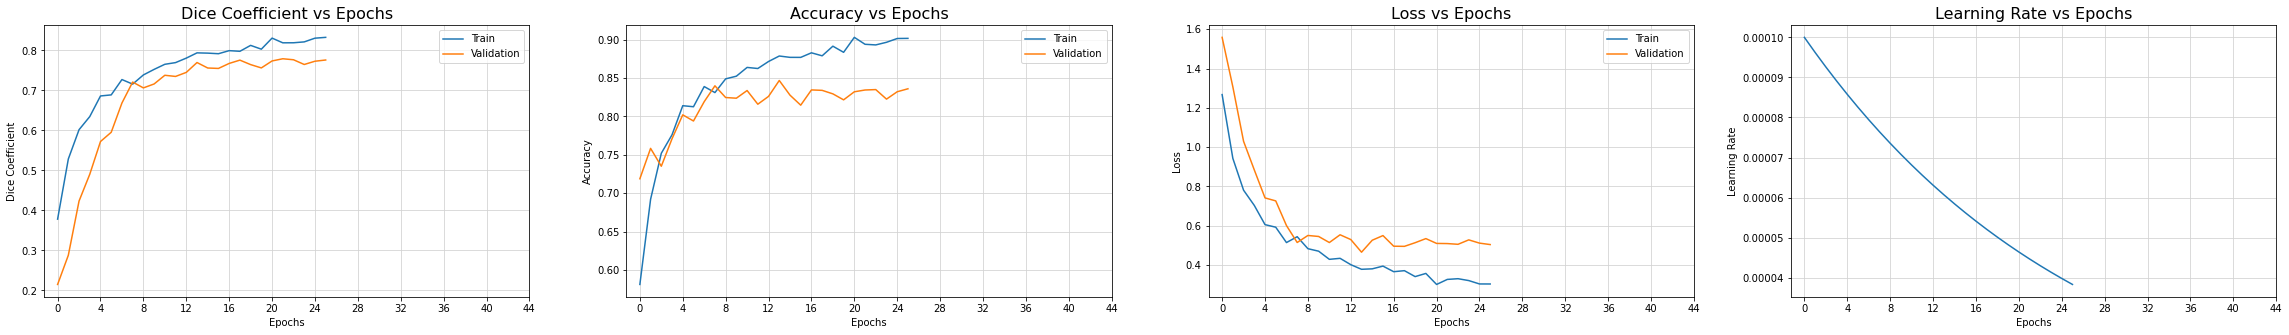

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(40, 5))
ax = ax.ravel()
metrics = ['Dice Coefficient', 'Accuracy', 'Loss', 'Learning Rate']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss', 'lr']): 
    if met != 'lr':
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].legend(['Train', 'Validation'])
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    else:
        ax[i].plot(history.history[met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        
plt.savefig('./Output/model_metrics_plot.png', facecolor= 'w',transparent= False, bbox_inches= 'tight', dpi= 150)

## Visualizing the predictions

In [19]:
model.load_weights("./InceptionResNetV2-UNet.h5")

In [20]:
testing_gen = ValAugmentGenerator(val_images_dir = val_images, val_masks_dir = val_masks, target_size = (512, 512))

In [21]:
!mkdir predictions

A subdirectory or file predictions already exists.


Found 16 images belonging to 1 classes.
Found 16 images belonging to 1 classes.


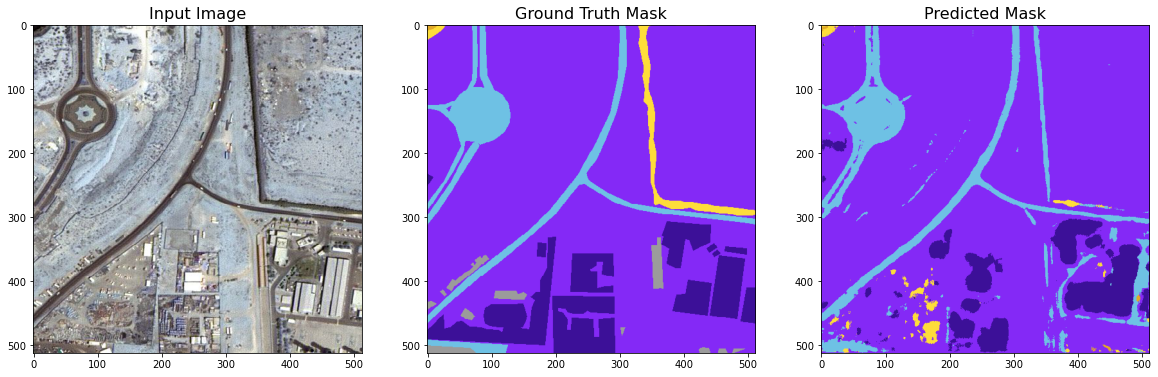

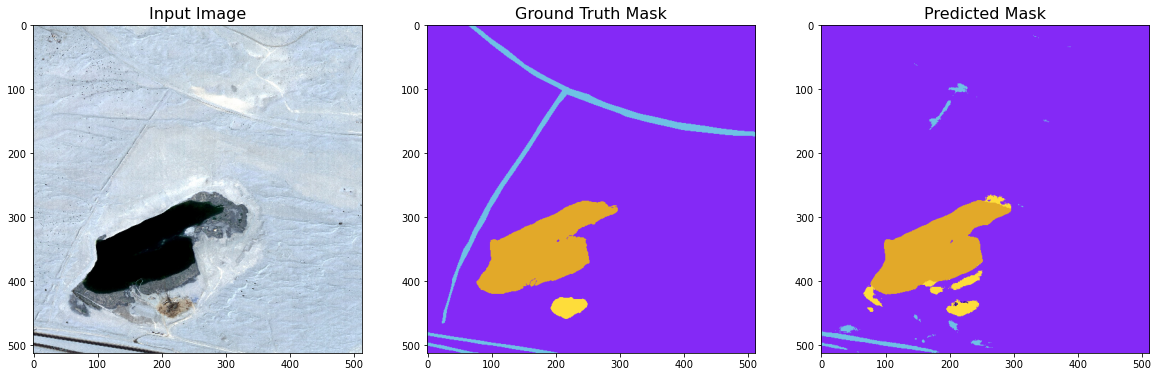

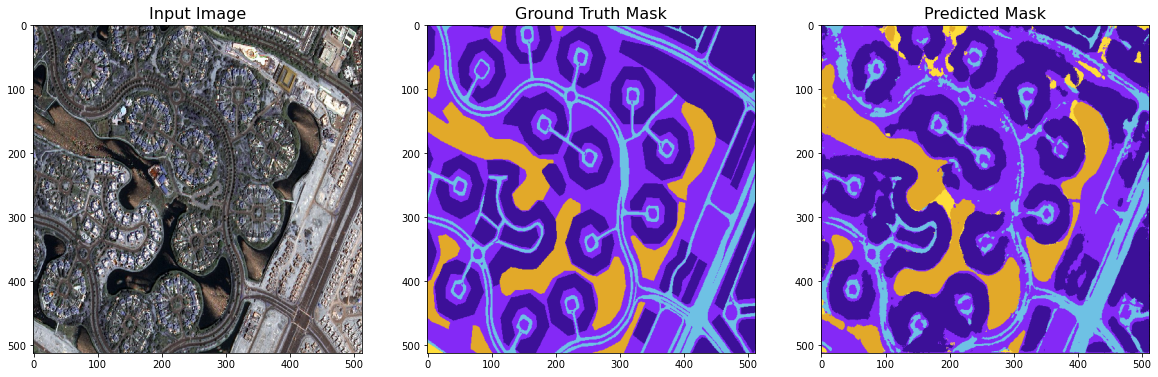

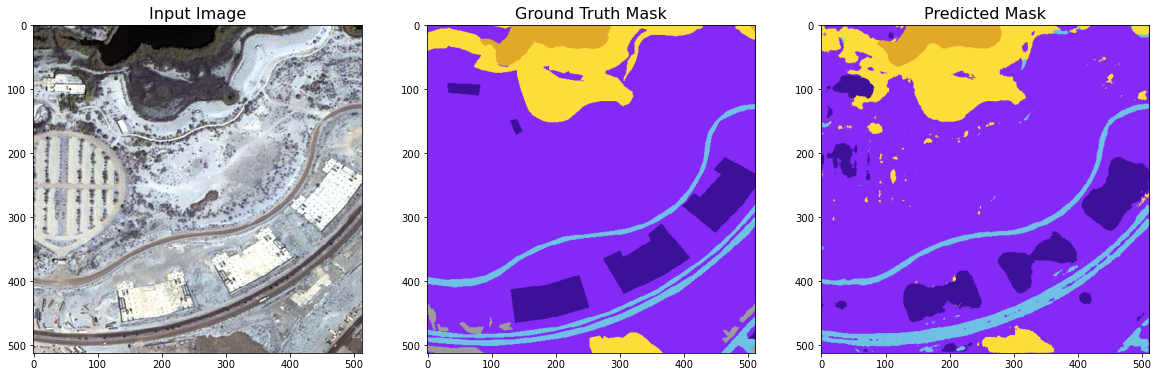

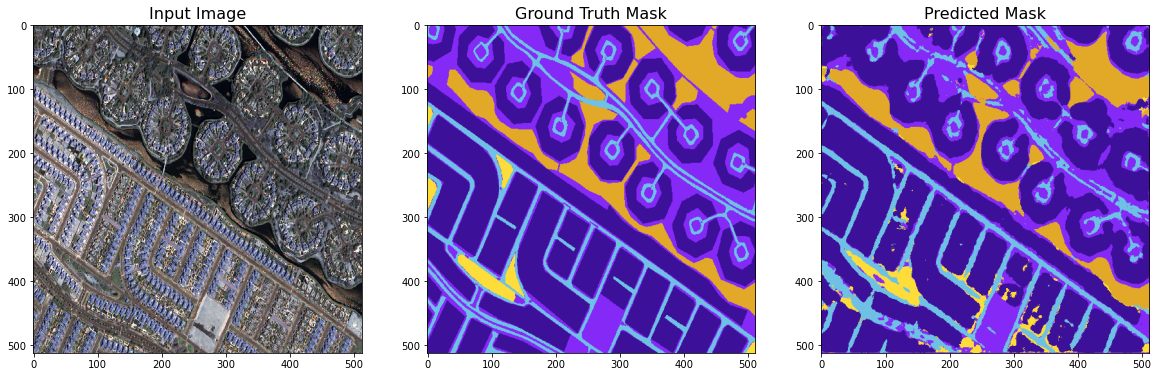

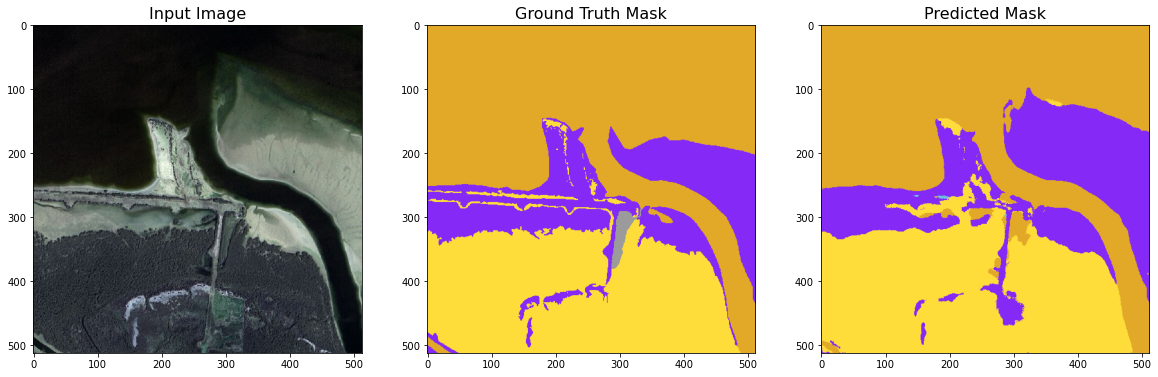

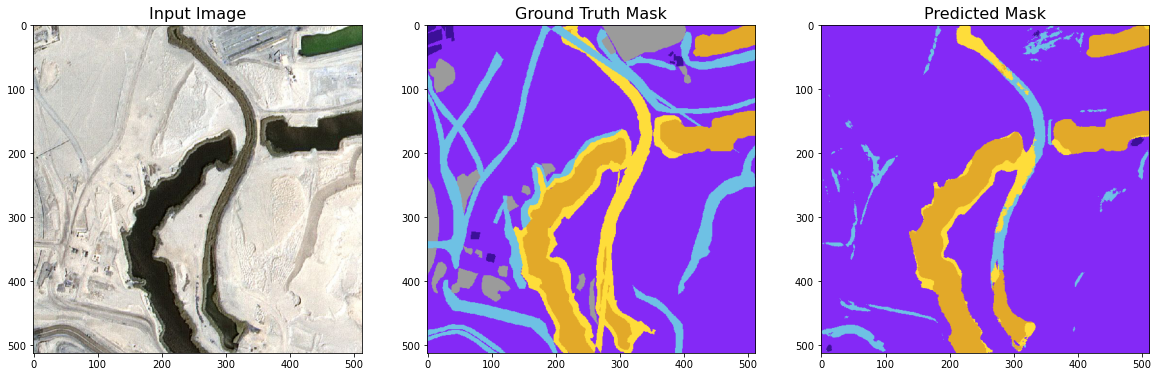

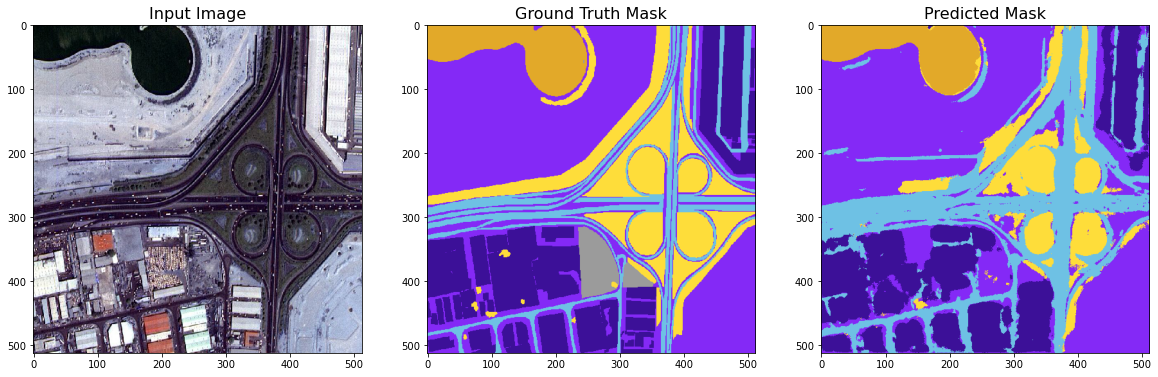

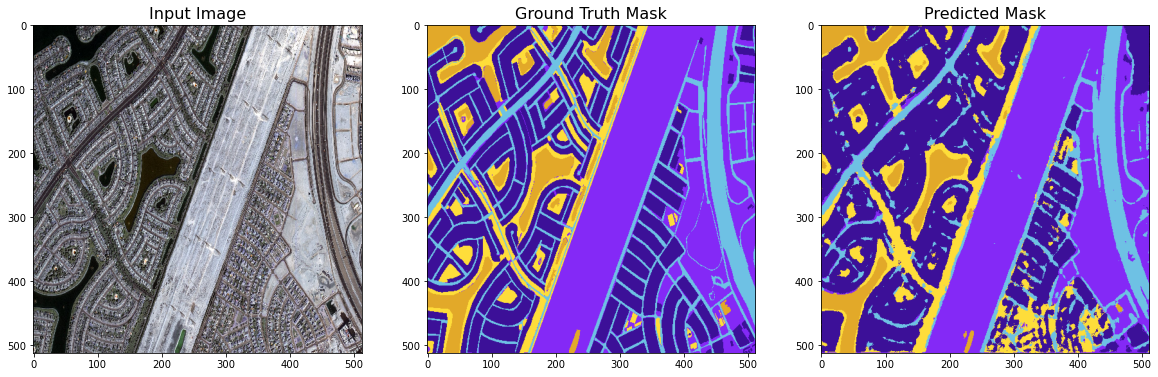

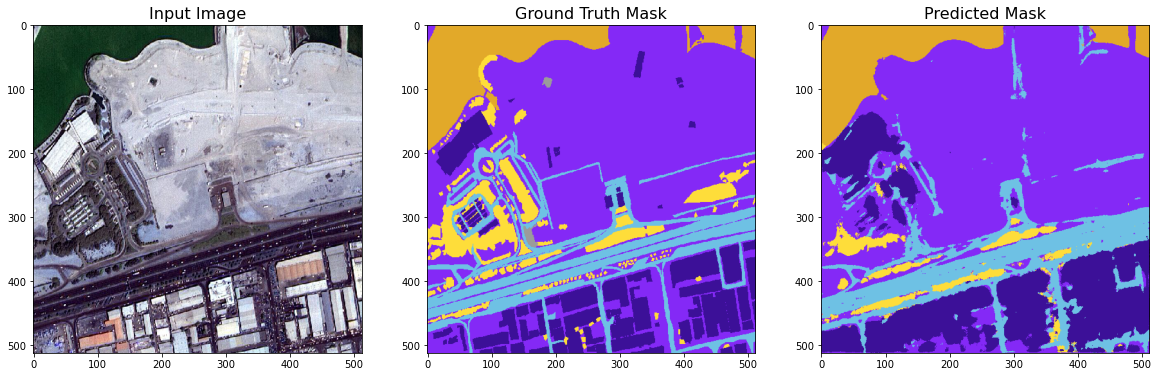

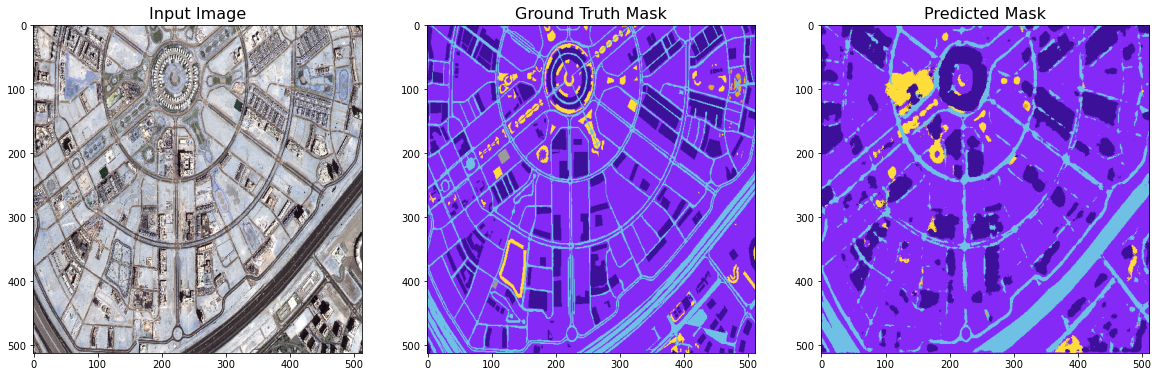

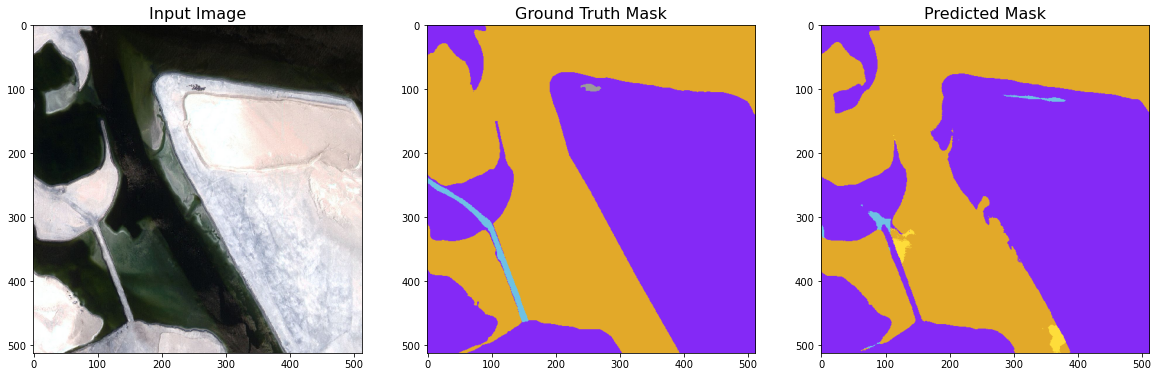

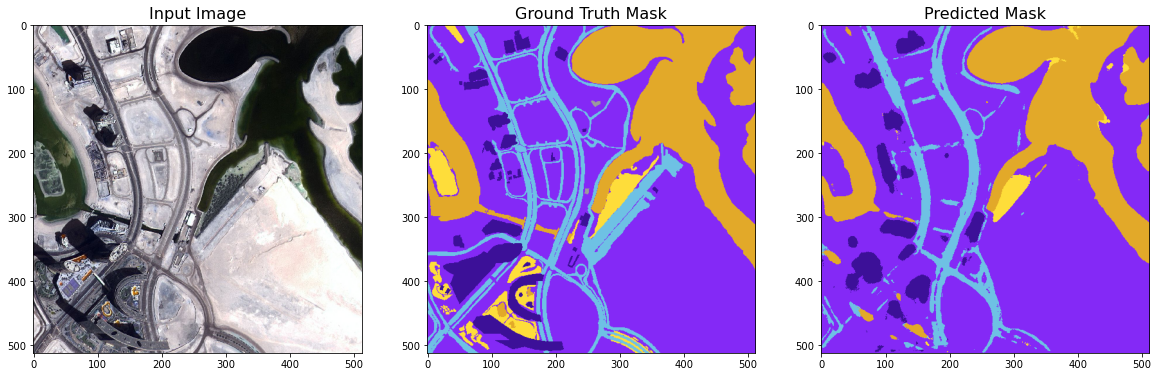

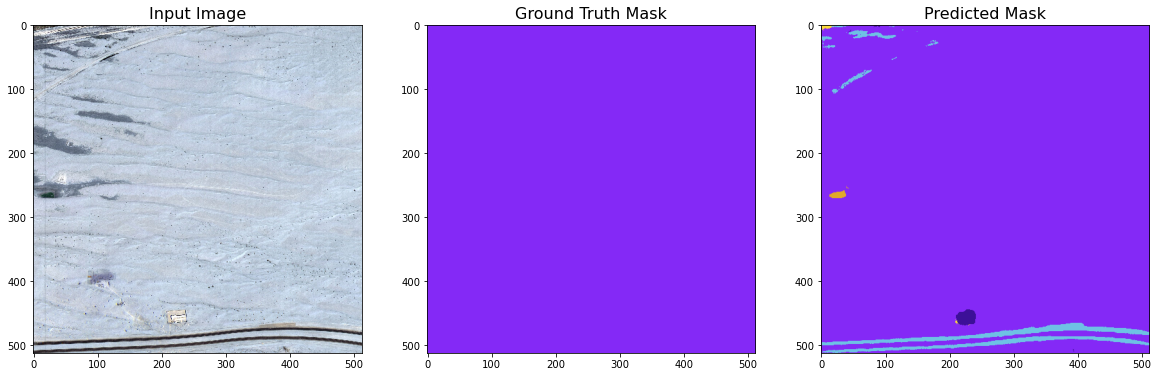

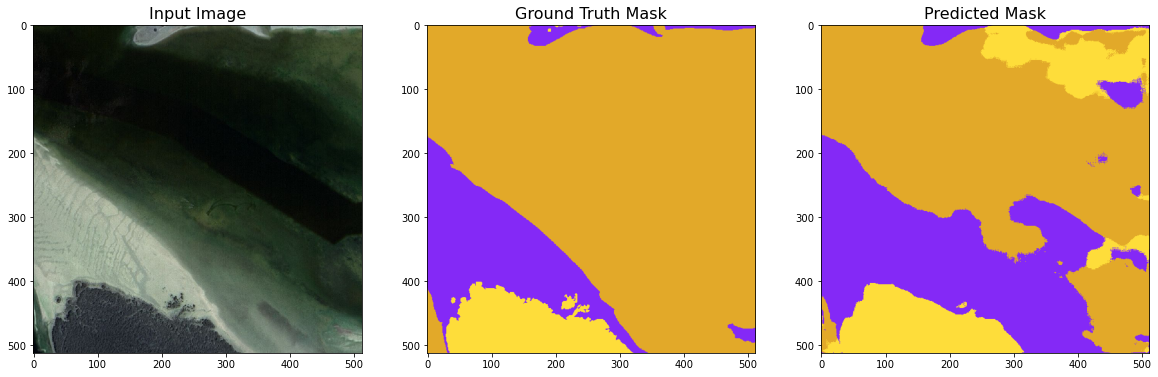

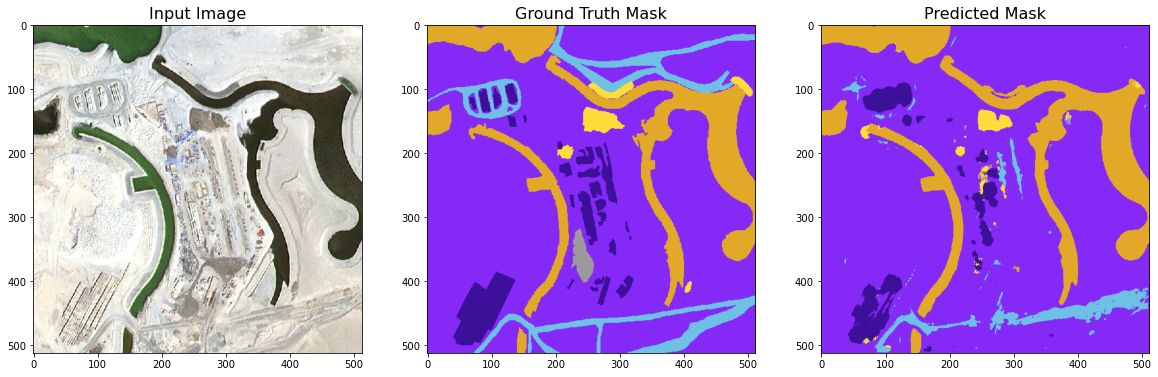

In [22]:
count = 0
for i in range(2):
    batch_img,batch_mask = next(testing_gen)
    pred_all= model.predict(batch_img)
    np.shape(pred_all)
    
    for j in range(0,np.shape(pred_all)[0]):
        count += 1
        fig = plt.figure(figsize=(20,8))

        ax1 = fig.add_subplot(1,3,1)
        ax1.imshow(batch_img[j])
        ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax1.grid(False)

        ax2 = fig.add_subplot(1,3,2)
        ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax2.imshow(onehot_to_rgb(batch_mask[j],id2code))
        ax2.grid(False)

        ax3 = fig.add_subplot(1,3,3)
        ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax3.imshow(onehot_to_rgb(pred_all[j],id2code))
        ax3.grid(False)

        plt.savefig('./predictions/prediction_{}.png'.format(count), facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 200)
        plt.show()